# Forecasting Individual ATMs

In [5]:
from feature_generation import *
from forecasting import *
from plotting import *

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("DATA_sample_atm.csv")
targets = ['CashIn', 'CashOut']
atm_df = get_atm(df, 26637)
atm_df = atm_df[:-135]
atm_df = clean_data(atm_df, drop_zeros=True)

<AxesSubplot:xlabel='HistoryDate'>

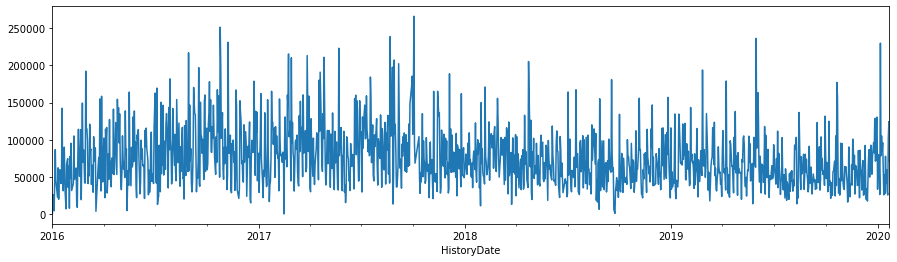

In [3]:
atm_df['CashIn'].plot(figsize=(15,4))

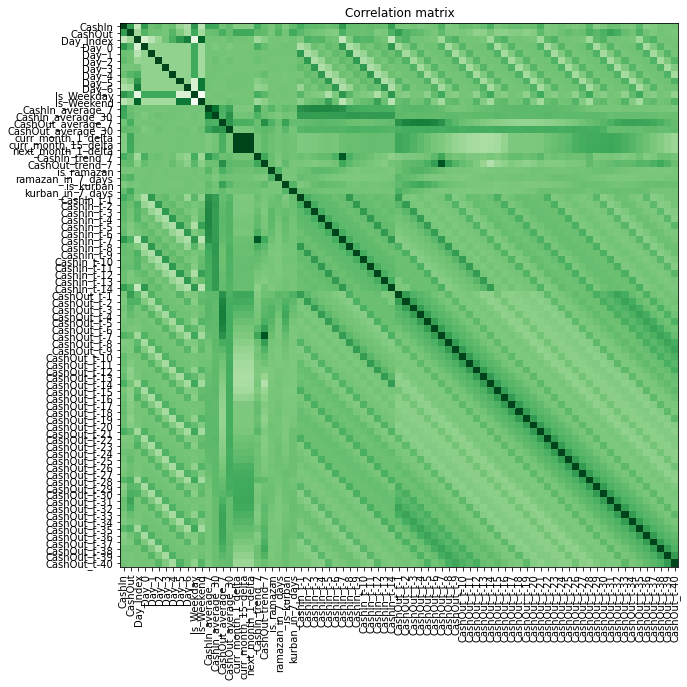

In [6]:
feature_set = get_feature_sets(atm_df, targets)
correlation(feature_set)

There is a visible difference in the correlation matrix when compared with the aggreagate correlation.

In [7]:
shifted_errors = get_shifted_errors(atm_df[targets], 21, average=[[7,14], [7,14,21]])

In [8]:
shifted_errors.sort_values(by='CashIn_Error')[:3]

,CashIn_Error,CashOut_Error
"t-(7,14)",78.862862,inf
"t-(7,14,21)",79.782546,inf
t-14,81.721763,inf


In [9]:
shifted_errors.sort_values(by='CashOut_Error')[:3]

,CashIn_Error,CashOut_Error
t-1,83.018026,inf
t-21,94.850135,inf
t-20,116.290436,inf


Because we there are low values in the dataset, MAPE is calculating astronomical errors

## Random Forest

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [11]:
target = 'CashIn'

X = feature_set[feature_set.columns[2:]]
y = feature_set[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

print("Predicting: %s" % target)

Predicting: CashIn


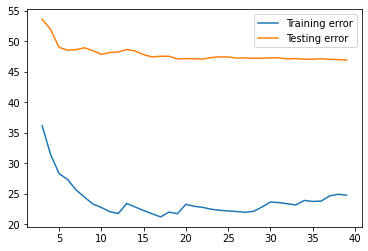

Best test error: 46.888 with 39 trees.


In [12]:
compare_model_parameter(RandomForestRegressor, X, y, 'n_estimators', list(range(3,40)), shuffle=False)

In [13]:
forest = RandomForestRegressor(n_estimators=34, random_state=5)
forest.fit(X_train, y_train)
print("Training error: %.4f" % mape_error(y_train, forest.predict(X_train)))
print("Testing error:  %.4f" % mape_error(y_test, forest.predict(X_test)))

Training error: 23.8849
Testing error:  47.0174


In [14]:
draw_model_error(forest, X, y, split_from=X_train.index[-1])

## LGBM

In [17]:
import optuna
from lightgbm import LGBMRegressor

In [18]:
def objective(trial,data=X,target=y):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, shuffle=False, test_size=0.2)
    param = {
        'metric': 'mape', 
        'random_state': 48,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    model = LGBMRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(test_x)
    
    mape = mape_error(test_y, preds)
    
    return mape

In [21]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=150)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best value:', study.best_value)

[I 2021-07-11 17:41:54,671] A new study created in memory with name: no-name-6df45a59-864a-49dc-99a0-839f3e91017e
[I 2021-07-11 17:42:16,703] Trial 0 finished with value: 48.67701739523699 and parameters: {'reg_alpha': 4.772279359114797, 'reg_lambda': 0.2347144241643462, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 247, 'min_child_samples': 2, 'min_data_per_groups': 84}. Best is trial 0 with value: 48.67701739523699.
[I 2021-07-11 17:42:18,133] Trial 1 finished with value: 47.07022799718987 and parameters: {'reg_alpha': 0.15850481847202505, 'reg_lambda': 0.002915303883551269, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 660, 'min_child_samples': 66, 'min_data_per_groups': 90}. Best is trial 1 with value: 47.07022799718987.
[I 2021-07-11 17:42:18,599] Trial 2 finished with value: 46.49239151795694 and parameters: {'reg_alpha': 0.0594393440561259, 'reg_lambda': 0.09387423593736292, 'c

Number of finished trials: 150
Best trial: {'reg_alpha': 0.14610002666115568, 'reg_lambda': 1.3192024603818329, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 503, 'min_child_samples': 165, 'min_data_per_groups': 4}
Best value: 44.733408933395204


In [22]:
optuna.visualization.plot_optimization_history(study)

In [23]:
params=study.best_params   
#params = {'reg_alpha': 1.483192630608853, 'reg_lambda': 0.36626510385236044, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 348, 'min_child_samples': 6, 'min_data_per_groups': 91}
params['random_state'] = 48
params['n_estimators'] = 20000 
params['metric'] = 'mape'
params['cat_smooth'] = params.pop('min_data_per_groups')

In [25]:
from sklearn.model_selection import KFold

folds = KFold(n_splits = 10, shuffle=False)

predictions = np.zeros(len(X_test))

for fold, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    
    X_tra, X_val = X_train.iloc[trn_idx], X_train.iloc[val_idx]
    y_tra, y_val = y_train.iloc[trn_idx], y_train.iloc[val_idx]

    model = LGBMRegressor(**params)
   
    model.fit(X_tra, y_tra, eval_set = [(X_val, y_val)], eval_metric = 'mape', verbose = False, early_stopping_rounds = 222)
    
    predictions += model.predict(X_test) / folds.n_splits 

In [26]:
weekly_errors = get_error_with_freq(y_test, predictions, 'w')
draw_error_over_time(y_test, predictions, weekly_errors, X_train.index[-1])

In [27]:
"Test error of LGBM is %.3f." % mape_error(y_test, predictions)

'Test error of LGBM is 48.685.'